<a href="https://colab.research.google.com/github/mohiteprathamesh1996/Investment-and-Portfolio-Analysis-of-Stocks/blob/main/PortfolioOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing packages

In [10]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

!pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

     |████████████████████████████████| 51kB 2.8MB/s 


#### Get returns and risk at status quo 

In [11]:
def ideal_return_volatility(list_of_assets):
  # Assign equal weightage to each asset
  assign_weights = np.array([1/len(list_of_assets) for i in list_of_assets])

  # Fetch live data
  df = pdr.get_data_yahoo(list_of_assets, 
                          start=str(datetime.date.today()-datetime.timedelta(days=365)),
                          end=str(datetime.date.today()))["Adj Close"]
  
  # Get per day return %
  returns = df.pct_change()

  # Get annual covariance matrix
  annual_cov_matrix = returns.cov() * df.shape[0]
  
  # Calculate net portfolio variance
  portfolio_variance = np.dot(assign_weights.T, np.dot(annual_cov_matrix, assign_weights))
  
  # Calculate net portfolio volatility
  portfolio_volatility = np.sqrt(portfolio_variance)
  
  # Calculate simple annual return
  simple_annual_return = np.sum(returns.mean()*assign_weights) * df.shape[0]
  
  print("Expected annual return = ",round(simple_annual_return*100, 2), "%")
  print("Annual volatility = ",round(portfolio_volatility*100, 2), "%") 

#### Optimizing the portfolio of assets with an objective to maximize returns given other risks

In [20]:
def optimized_portfolio(list_of_assets, budget):
  '''
  Runs a simulation to generate portfolio of assets with an objective to maximize returns given other risks.
  
  Parameters:
  -----------  
      list_of_assets: list
          all the assets that are to be pulled from pandas datareader to comprise.    
      
      budget: int 
          amount of investment in US $.

  '''
  # Fetch live data
  df = pdr.get_data_yahoo(list_of_assets, 
                          start=str(datetime.date.today()-datetime.timedelta(days=365)),
                          end=str(datetime.date.today()))["Adj Close"]

  # Get the latest price
  latest_price = get_latest_prices(df)

  # Get average expected return
  mean_expected_return = expected_returns.mean_historical_return(df)

  # Generate sample covariance matrix to measure relative price fluctuation
  sample_covariance_matrix = risk_models.sample_cov(df)

  plt.rcParams["figure.figsize"] = (10, 5)
  plt.rcParams["font.size"] = 12
  plot_efficient_frontier(CLA(mean_expected_return, sample_covariance_matrix))
  plt.show()

  print("\n At a given budget of USD ${}, \n".format(budget))


  # Fitting the Efficient Frontier to obtain optimized weights for each asset
  print("If Objective -> Optimized Portfolio to Maximize Expected Return: \n")
  ef_max_sharpe = EfficientFrontier(mean_expected_return, sample_covariance_matrix)
  clean_weights_max_sharpe = ef_max_sharpe.max_sharpe()
  print(clean_weights_max_sharpe)
  ef_max_sharpe.portfolio_performance(verbose=True)
  print("\nProposed discrete allocation plan")
  d_allocate = DiscreteAllocation(clean_weights_max_sharpe, latest_price, total_portfolio_value=budget)
  allocated, balance = d_allocate.greedy_portfolio()
  print(allocated)
  print("Remaining Balance = $", round(balance, 2))
  
  
  print("\n*****************************************************************************************\n")
  print("If Objective -> Optimized Portfolio to Minimize Volatility: \n")
  ef_min_risk = EfficientFrontier(mean_expected_return, sample_covariance_matrix)
  clean_weights_min_risk = ef_min_risk.min_volatility()
  print(clean_weights_min_risk)
  ef_min_risk.portfolio_performance(verbose=True)
  print("\nProposed discrete allocation plan")
  d_allocate = DiscreteAllocation(clean_weights_min_risk, latest_price, total_portfolio_value=budget)
  allocated, balance = d_allocate.greedy_portfolio()
  print(allocated)
  print("Remaining Balance = $", round(balance, 2))

In [21]:
assets = ["CRM", "CRWD", "ETSY", "QRVO", "JD", "TTM"]

In [22]:
ideal_return_volatility(list_of_assets=["FB","AMZN","AAPL","NFLX","GOOGL"])

Expected annual return =  56.54 %
Annual volatility =  37.02 %


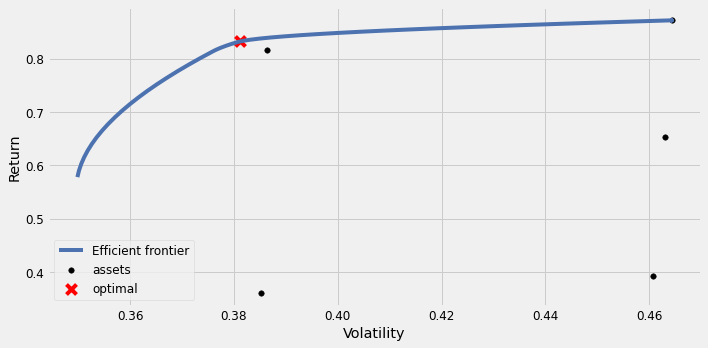


 At a given budget of USD $10000, 

If Objective -> Optimized Portfolio to Maximize Expected Return: 

OrderedDict([('FB', 0.0), ('AMZN', 0.7040956199226345), ('AAPL', 0.2959043800773654), ('NFLX', 0.0), ('GOOGL', 0.0)])
Expected annual return: 83.3%
Annual volatility: 38.1%
Sharpe Ratio: 2.13

Proposed discrete allocation plan
{'AMZN': 2, 'AAPL': 24}
Remaining Balance = $ 740.84

*****************************************************************************************

If Objective -> Optimized Portfolio to Minimize Volatility: 

OrderedDict([('FB', 0.0), ('AMZN', 0.3824307002565602), ('AAPL', 0.0), ('NFLX', 0.1463828365992051), ('GOOGL', 0.4711864631442346)])
Expected annual return: 57.8%
Annual volatility: 35.0%
Sharpe Ratio: 1.60

Proposed discrete allocation plan
{'GOOGL': 2, 'AMZN': 1, 'NFLX': 3}
Remaining Balance = $ 1694.97


In [23]:
optimized_portfolio(list_of_assets=["FB","AMZN","AAPL","NFLX","GOOGL"], budget=10000)